# Catégorisation automatique des questions 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from datetime import datetime
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers
import gensim.corpora as corpora
from pprint import pprint
from sklearn.metrics import hamming_loss
import joblib

# Importation de des données nottoyées

In [70]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [71]:
df_cleaned = pd.read_csv("/home/alseny/Documents/Proje5_NLP/Donnees/QueryResultCleaneed.csv")
df_cleaned.head()

,Tags,Posts,PostsClean
0,['c#'],How to convert Decimal to Double in C#? I want...,convert decimal double want assign decimal var...
1,"['c#', '.net']",How do I calculate someone's age based on a Da...,calculate someone based datetime type birthday...
2,['c#'],Calculate relative time in C# Given a specific...,calculate relative time given specific value d...
3,['.net'],Difference between Math.Floor() and Math.Trunc...,difference mathfloor mathtruncate difference
4,['c#'],Filling a DataSet or a DataTable from a LINQ q...,filling dataset datatable linq query result ex...


In [72]:
df_clean = df_cleaned.copy()

In [73]:
df_clean.Tags[0]

"['c#']"

In [74]:
import ast
df_clean.Tags = df_clean.Tags.apply(lambda x : ast.literal_eval(x))

In [75]:
df_clean.Tags[0]

['c#']

In [76]:
#df_clean.Tags.unique() # affichage des différentes modalités de variable cible Tags

In [77]:
## Affichage de quelques lignes avec les tags correspondan
def print_plot(index):  
    example = df_clean[df_clean.index == index][['PostsClean', 'Tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])
print_plot(3)

difference mathfloor mathtruncate difference
Tag: ['.net']


In [78]:
print_plot(4)

filling dataset datatable linq query result expose linq query asmx service

usually business tier return typed serialized transport asmx
how linq query populate typed linq query
 
how could result linq query 

alternatively linq query serializable expose asmx service
Tag: ['c#']


In [79]:
print_plot(3)

difference mathfloor mathtruncate difference
Tag: ['.net']


In [80]:
df_clean.drop(["Posts"], axis=1, inplace=True)## Suppression de la variable "Posts"

In [81]:
df_clean.head()

,Tags,PostsClean
0,[c#],convert decimal double want assign decimal var...
1,"[c#, .net]",calculate someone based datetime type birthday...
2,[c#],calculate relative time given specific value d...
3,[.net],difference mathfloor mathtruncate difference
4,[c#],filling dataset datatable linq query result ex...


In [82]:
df_clean = df_clean[0:600]
df_clean.shape

(600, 2)

### Représentation des postes après traitement

In [83]:
all_words_lem = ' '.join([word for word in df_clean['PostsClean']])

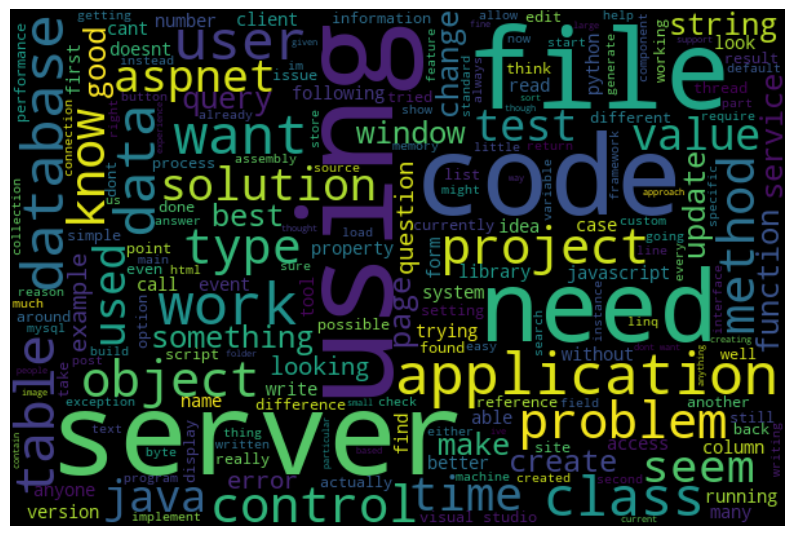

In [84]:
wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

# Modélisation

## Modèle non supervise

### LDA (Latent Dirichlet Allocation)

In [23]:
import gensim
from gensim import corpora, models

In [24]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  
        sent = re.sub('\s+', ' ', sent)  
        sent = re.sub("\'", "", sent)  
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convertire en liste
data = df_clean.PostsClean.values.tolist()
data_words = list(sent_to_words(data))

In [25]:
data_words[:1]

[['convert',
  'decimal',
  'double',
  'want',
  'assign',
  'decimal',
  'variable',
  'trans',
  'double',
  'variable',
  'thisopacity',
  'when',
  'build',
  'give',
  'following',
  'error',
  'cannot',
  'implicitly',
  'convert',
  'type',
  'decimal',
  'double']]

In [26]:
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 3), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1)]


### Nuages de mots des N principaux mots-clés dans chaque sujet

In [27]:
# nombre de topics
num_topics = 9
# model LDA
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=100,
                                       chunksize=10,
                                       iterations=5,
                                        alpha='symmetric'
                                      )
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"control" + 0.011*"using" + 0.009*"application" + 0.009*"server" + '
  '0.008*"object" + 0.008*"code" + 0.008*"aspnet" + 0.008*"want" + '
  '0.007*"would" + 0.007*"event"'),
 (1,
  '0.011*"page" + 0.010*"code" + 0.010*"like" + 0.009*"would" + 0.009*"using" '
  '+ 0.009*"application" + 0.008*"need" + 0.008*"work" + 0.008*"control" + '
  '0.007*"make"'),
 (2,
  '0.018*"server" + 0.011*"code" + 0.010*"application" + 0.010*"would" + '
  '0.009*"using" + 0.007*"query" + 0.007*"client" + 0.007*"window" + '
  '0.007*"need" + 0.007*"want"'),
 (3,
  '0.011*"button" + 0.011*"server" + 0.009*"using" + 0.009*"like" + '
  '0.009*"would" + 0.008*"work" + 0.008*"code" + 0.008*"project" + '
  '0.008*"class" + 0.007*"java"'),
 (4,
  '0.010*"would" + 0.010*"class" + 0.010*"like" + 0.010*"know" + 0.009*"using" '
  '+ 0.008*"aspnet" + 0.008*"object" + 0.007*"file" + 0.007*"server" + '
  '0.006*"form"'),
 (5,
  '0.014*"time" + 0.013*"using" + 0.009*"would" + 0.008*"work" + 0.008*"like" '
  '+

## Nuages des principaux mots-clés dans chaque sujet

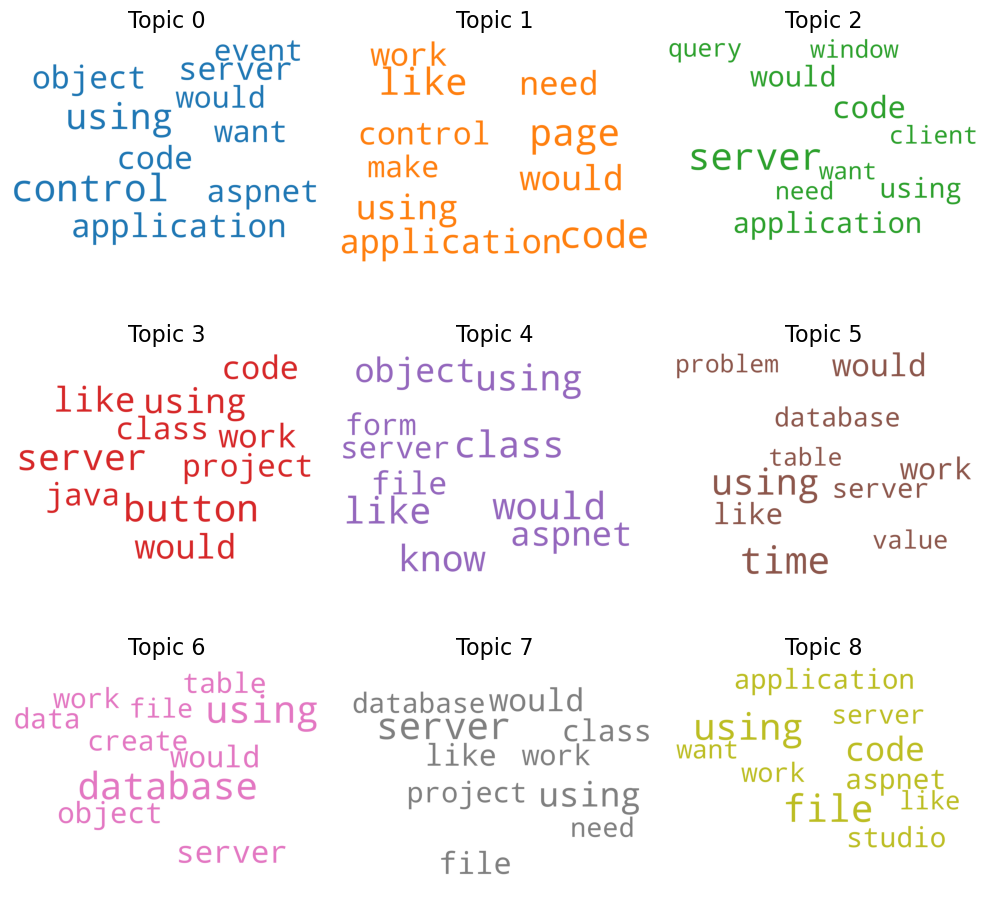

In [28]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [29]:
from nltk.corpus import stopwords

## Fréquence d'apparition des mots-clés du sujet dans les documments 

/tmp/ipykernel_17973/2672809095.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


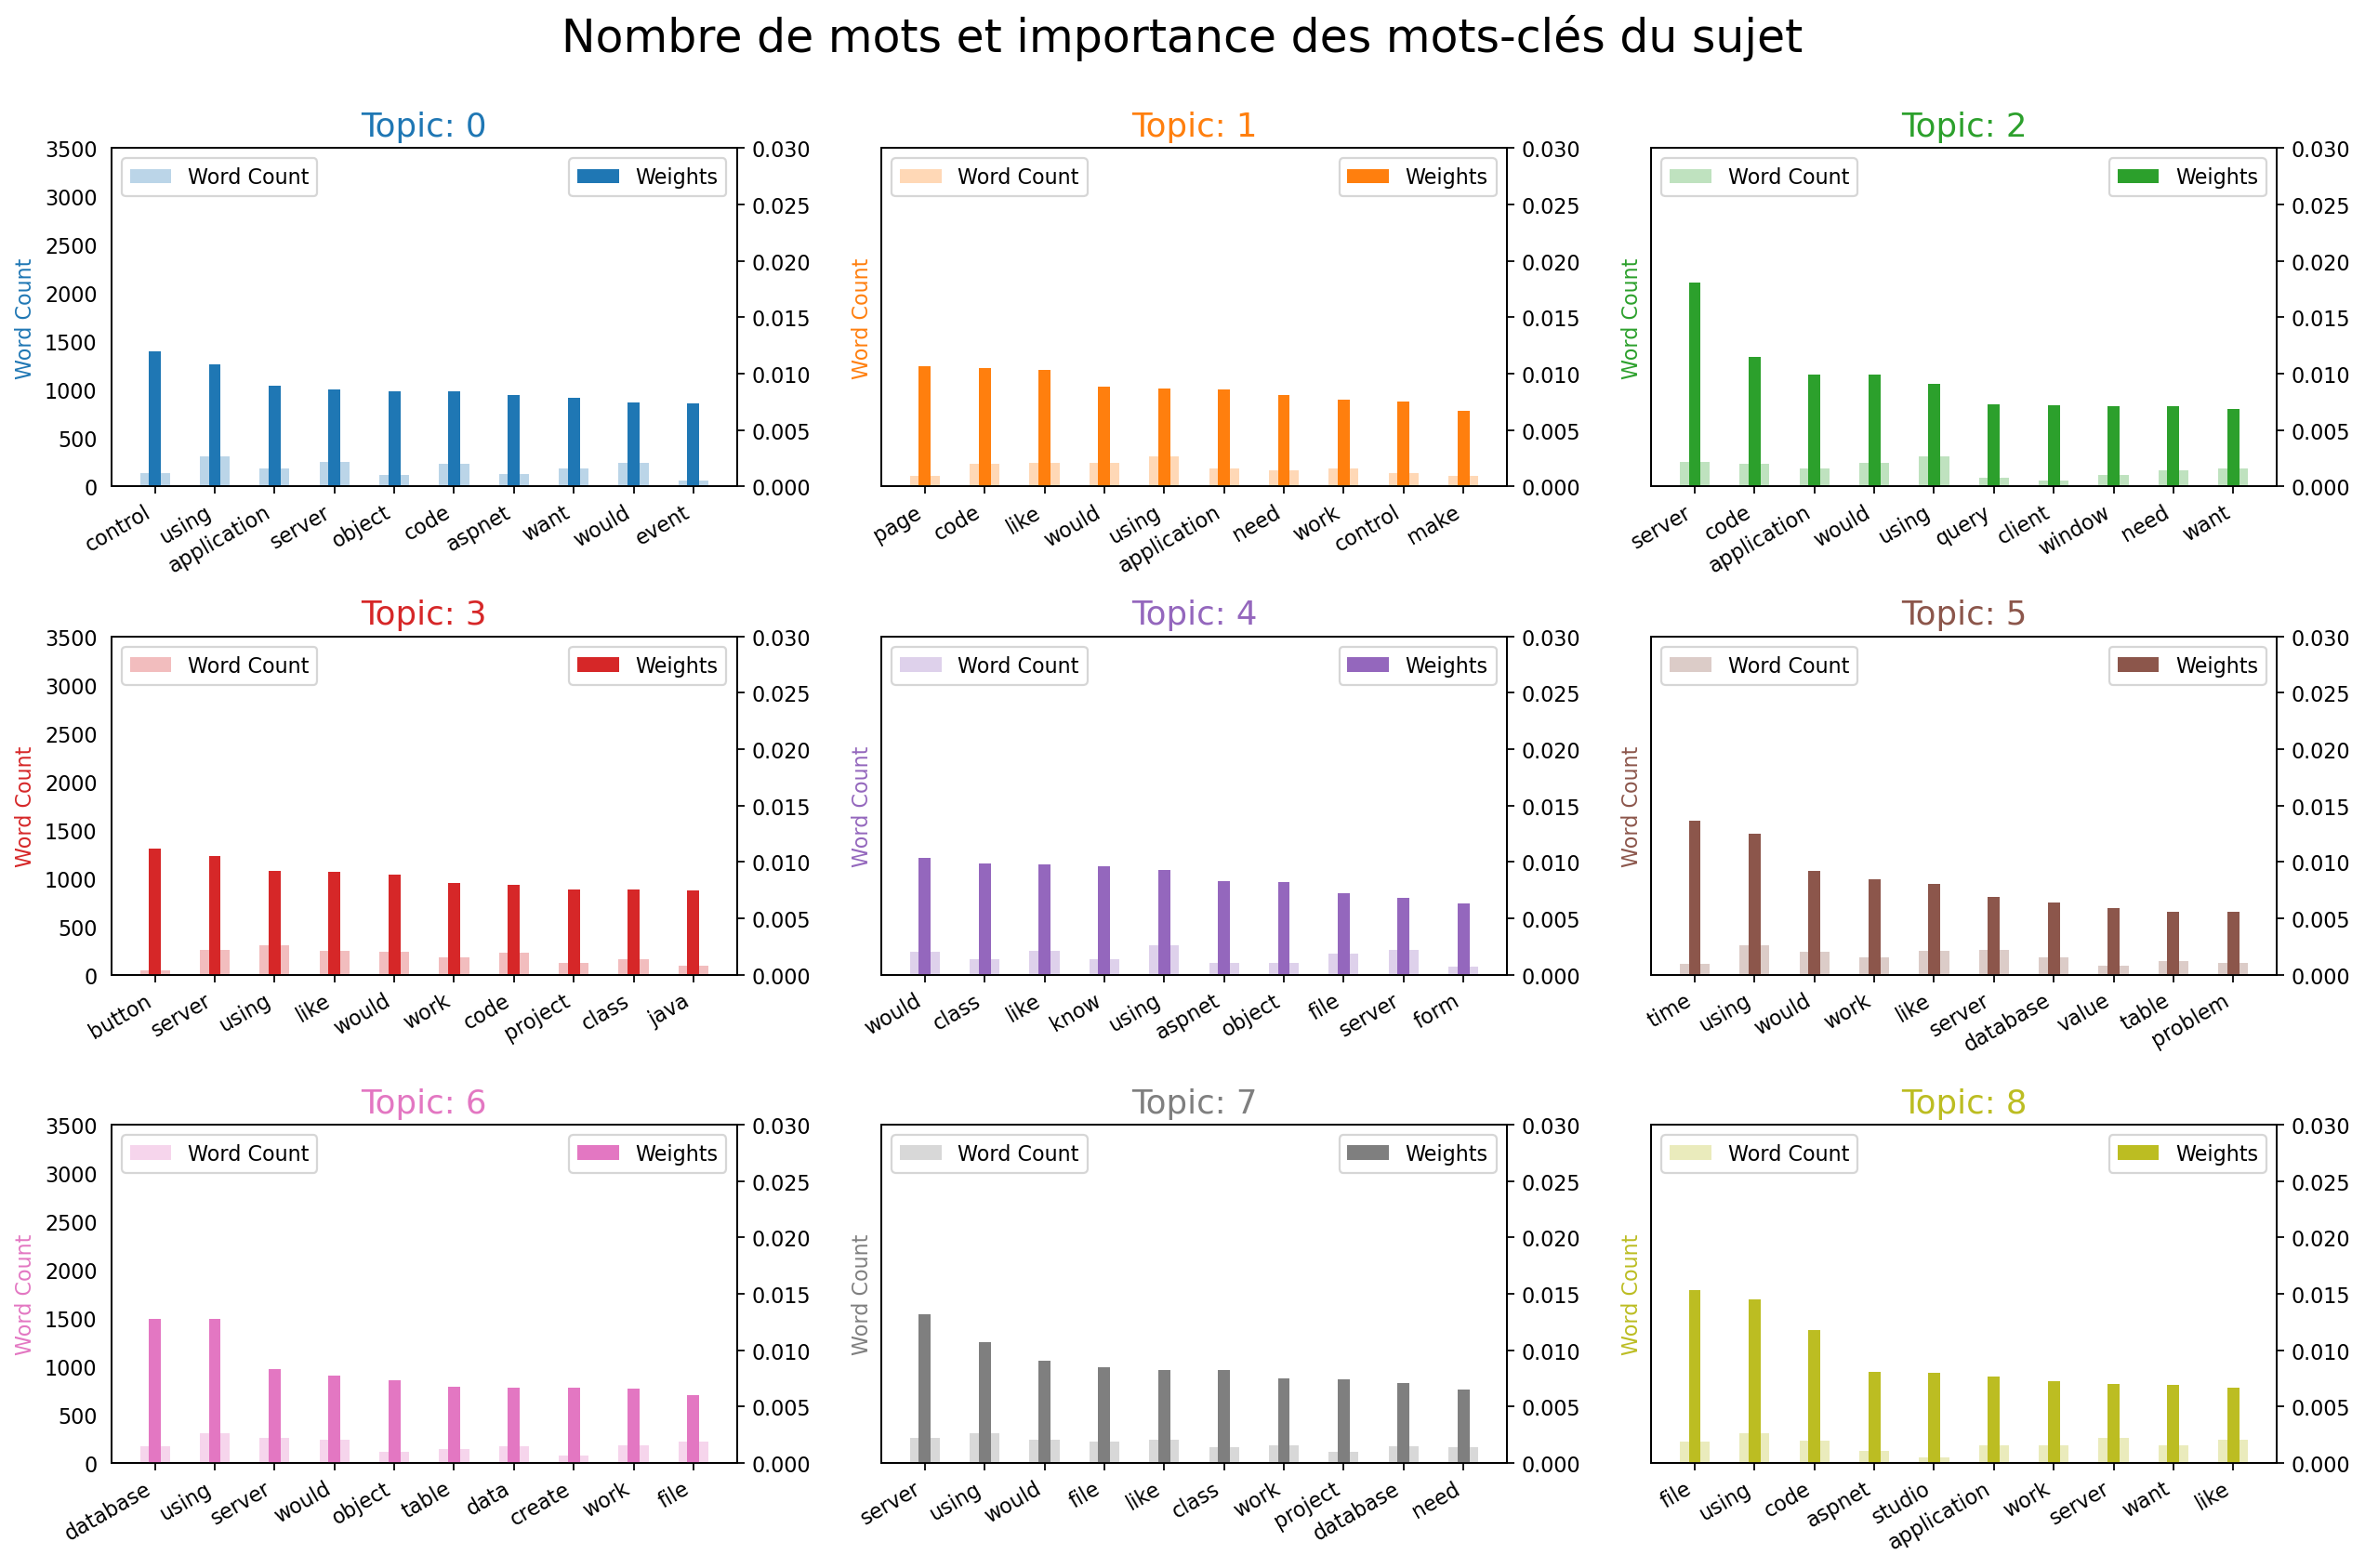

In [30]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Traçage du nombre de mots et le poids des mots-clés du sujet
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Nombre de mots et importance des mots-clés du sujet', fontsize=22, y=1.05)    
plt.show()

## Models supervisés
En premier lieu, nous appliquerons 4 approches d'encodeur (TF-IDF, Word2Vec, BERT, USE) sur les données et par la suite entrainer les modèles d'apprentissage supervisés, puis comparer leurs performance et enfin, deployer le modèle finale dans un cloude.

In [20]:
#conda deactivate
#!pip install tensorflow

## TF-IDF &  SGD (Stochastic Gradient Descent)

In [110]:
X = df_clean['PostsClean']

y = df_clean['Tags']

multilabel_binarizer = MultiLabelBinarizer()

y_target = multilabel_binarizer.fit_transform(y)

# Divisé en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.3, random_state=42)

In [112]:
# Initialisons le vectoriseur avec nombre de mots maximum et ngrammes (1 : mots simples, 2 : deux mots d'affilée)
#fonctionnalités maximales = 15 000, ngram_range = (1,2)
vectorizer_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

## Conception du modèle SGDClassifier

In [113]:
sgd_classifier_tf = MultiOutputClassifier(SGDClassifier())

In [114]:
model_sgd = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", sgd_classifier_tf)])

start_time = datetime.now()

model_sgd.fit(X_train, y_train)

end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

In [115]:
predicted_train_tfidf = model_sgd.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_sgd.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))
print('Training time: {:.1f}s'.format(training_time_tfidf))
print(classification_report(y_test, predicted_test_tfidf))

Accuracy Training data: 100.0%
Accuracy Test data: 29.4%
Training time: 0.2s
              precision    recall  f1-score   support

           0       0.50      0.26      0.34        39
           1       0.73      0.57      0.64        14
           2       0.52      0.45      0.48        49
           3       0.00      0.00      0.00        25
           4       0.92      0.65      0.76        17
           5       0.88      0.58      0.70        12
           6       0.67      0.12      0.20        17
           7       1.00      0.67      0.80         9
           8       0.75      0.18      0.29        17
           9       0.68      0.62      0.65        24

   micro avg       0.66      0.38      0.48       223
   macro avg       0.66      0.41      0.49       223
weighted avg       0.59      0.38      0.44       223
 samples avg       0.40      0.40      0.39       223



/home/alseny/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alseny/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
ex="difference mathfloor mathtruncate difference"

In [117]:
ex2="filling dataset datatable linq query result expose linq query asmx service usually business tier return typed serialized transport asmx how linq query populate typed linq query how could result linq query alternatively linq query serializable expose asmx service"

In [118]:
model_sgd.predict([ex2])

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [119]:
multilabel_binarizer.inverse_transform(model_sgd.predict([ex2]))

[('c#',)]

###############################################################
#################################################################

## WORD2VEC &  SGD (Stochastic Gradient Descent)

In [120]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
from gensim.models import word2vec

In [121]:
X = df_clean['PostsClean']

target = df_clean['Tags']

multilabel_binarizer = MultiLabelBinarizer()

y_target = multilabel_binarizer.fit_transform(target)


# Repartition en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.30 , random_state=42)

In [122]:
model = word2vec.Word2Vec(X_train, window=20, min_count=2, workers=1)

In [123]:
model.corpus_count

420

In [124]:
import numpy

def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return numpy.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = numpy.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train, model)

wv_test_feat = word2vec_features(X_test, model)

## Conception du modèle SGDClassifier

In [125]:
sgd_classifierwv = MultiOutputClassifier(SGDClassifier())

In [126]:
start_time = datetime.now()

sgd_classifierwv.fit(wv_train_feat, y_train)

end_time = datetime.now()

training_time_wv = (end_time - start_time).total_seconds()

predicted_train_sgd = sgd_classifierwv.predict(wv_train_feat)

accuracy_train_sgd = accuracy_score(y_train, predicted_train_sgd)

print('Accuracy Training data: {:.1%}'.format(accuracy_train_sgd))

##########

sgd_classifierwv.score(wv_test_feat, y_test)

predicted_test_sgd = sgd_classifierwv.predict(wv_test_feat)

accuracy_wv = accuracy_score(y_test, predicted_test_sgd)

print('Accuracy Test data: {:.1%}'.format(accuracy_wv))

print('Training time: {:.1f}s'.format(training_time_wv))

print(classification_report(y_test, predicted_test_sgd))

Accuracy Training data: 1.4%
Accuracy Test data: 2.8%
Training time: 0.1s
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00        17
           9       0.86      0.25      0.39        24

   micro avg       0.86      0.03      0.05       223
   macro avg       0.09      0.03      0.04       223
weighted avg       0.09      0.03      0.04       223
 samples avg       0.03      0.03      0.03       223



/home/alseny/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alseny/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
###############################################
##############################################

## BERT &  SGD (Stochastic Gradient Descent)

In [128]:
X = df_clean['PostsClean']

target = df_clean['Tags']

multilabel_binarizer = MultiLabelBinarizer()

target = multilabel_binarizer.fit_transform(target)

# Répartition en ensembles de formation et de test
train_bert, test_bert, y_train_bert, y_test_bert = train_test_split(X, target, test_size=0.30 , random_state=42)

## Importation du modèle et Tokenisation

In [130]:
import torch
from transformers import AutoTokenizer, AutoModel

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

tokenized_train = tokenizer(train_bert.values.tolist(), padding = True, truncation = True, return_tensors="pt")
tokenized_val = tokenizer(test_bert.values.tolist() , padding = True, truncation = True,  return_tensors="pt")

In [132]:
tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

/tmp/ipykernel_3849/3006065455.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
/tmp/ipykernel_3849/3006065455.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [133]:
with torch.no_grad():
    hidden_train = model(**tokenized_train) # dim : [batch_size(nr_sentences), jetons, emb_dim]
    hidden_val = model(**tokenized_val)

In [134]:
# Obtention des états cachés [CLS]
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_val = hidden_val.last_hidden_state[:,0,:]

## Construction de classificateur

In [135]:
x_trainb = cls_train.to("cpu")
y_trainb = y_train_bert

x_valb = cls_val.to("cpu")
y_val = y_test_bert

In [136]:
print(x_trainb.shape, y_trainb.shape, x_valb.shape, y_val.shape)

torch.Size([420, 768]) (420, 10) torch.Size([180, 768]) (180, 10)


In [138]:
print(x_trainb.shape, y_trainb.shape, x_valb.shape, y_val.shape)

torch.Size([420, 768]) (420, 10) torch.Size([180, 768]) (180, 10)


In [139]:
sgd_classifier_ber = MultiOutputClassifier(SGDClassifier())

In [140]:
start_time = datetime.now()

sgd_classifier_ber.fit(x_trainb, y_trainb)

end_time = datetime.now()

training_time_bert = (end_time - start_time).total_seconds()

predicted_train_ber = sgd_classifier_ber.predict(x_trainb)

accuracy_train_ber = accuracy_score(y_trainb, predicted_train_ber)

print('Accuracy Training data: {:.1%}'.format(accuracy_train_ber))


predicted_test_bert = sgd_classifier_ber.predict(x_valb)

accuracy_test_bert = accuracy_score(y_val, predicted_test_bert)

print('Accuracy Training data: {:.1%}'.format(accuracy_test_bert))

print(classification_report(y_test, predicted_test_bert))

Accuracy Training data: 36.2%
Accuracy Training data: 10.6%
              precision    recall  f1-score   support

           0       0.33      0.05      0.09        39
           1       0.12      0.79      0.21        14
           2       0.49      0.47      0.48        49
           3       0.00      0.00      0.00        25
           4       0.50      0.29      0.37        17
           5       0.00      0.00      0.00        12
           6       0.33      0.12      0.17        17
           7       0.67      0.44      0.53         9
           8       0.00      0.00      0.00        17
           9       0.48      0.96      0.64        24

   micro avg       0.33      0.31      0.32       223
   macro avg       0.29      0.31      0.25       223
weighted avg       0.32      0.31      0.27       223
 samples avg       0.27      0.33      0.28       223



/home/alseny/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alseny/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## USE (Universal Sentence Encoder) & SGD (Stochastic Gradient Descent)

In [141]:
#!pip install tensorflow_hub

In [142]:
import tensorflow as tf
import tensorflow_hub as hub

In [143]:
import tensorflow_hub as hub

In [144]:
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [145]:
def sentences_encoder(col):
    sentences = col.tolist()
    
    sentence_vectors = use_model(sentences)
    
    return sentence_vectors

In [146]:
sentence_vectors = sentences_encoder(df_clean['PostsClean'])

In [147]:
sentence_vectors = sentence_vectors.numpy() # Convertir en tableau numpy

In [148]:
sentence_vectors

array([[-0.03885574, -0.07095027, -0.04573817, ...,  0.04916948,
         0.0527009 , -0.05415019],
       [-0.07954723, -0.08004172, -0.04472992, ...,  0.07186051,
         0.00330785,  0.00687244],
       [ 0.00762924, -0.0742323 , -0.07198462, ...,  0.07310573,
         0.02916867, -0.00795217],
       ...,
       [ 0.00221606, -0.04486952, -0.02588795, ...,  0.04751395,
        -0.016115  , -0.06794322],
       [-0.02143774, -0.03161005,  0.00049015, ...,  0.06644671,
         0.0119421 , -0.05748388],
       [-0.02416909,  0.02295421, -0.02507509, ...,  0.07300874,
        -0.00116117, -0.01253644]], dtype=float32)

## Repartition de données en données d'entrainement et données teste

In [149]:
target_use = df_clean['Tags']

multilabel_binarizer = MultiLabelBinarizer()

target_use = multilabel_binarizer.fit_transform(target_use)

In [150]:
train_use, test_use, y_train_use, y_test_use = train_test_split(sentence_vectors, target_use, test_size=0.30 , random_state=42)

In [151]:
train_use.shape, y_train_use.shape, test_use.shape, y_test_use.shape

((420, 512), (420, 10), (180, 512), (180, 10))

## Conception du modèle SGDClassifier

In [152]:
sgd_classifierUse = MultiOutputClassifier(SGDClassifier())

In [153]:
start_time = datetime.now()

sgd_classifierUse.fit(train_use, y_train_use)

end_time = datetime.now()

training_time_use = (end_time - start_time).total_seconds()

predicted_train = sgd_classifierUse.predict(train_use)

accuracy_train = accuracy_score(y_train_use, predicted_train)

print('Accuracy Training data: {:.1%}'.format(accuracy_train))


sgd_classifierUse.score(test_use, y_test_use)

predicted_test = sgd_classifierUse.predict(test_use)

accuracy_test_use = accuracy_score(y_test_use, predicted_test)

print('Accuracy Test data: {:.1%}'.format(accuracy_test_use))

print(classification_report(y_test_use, predicted_test))

Accuracy Training data: 91.9%
Accuracy Test data: 26.1%
              precision    recall  f1-score   support

           0       0.37      0.54      0.44        39
           1       0.57      0.86      0.69        14
           2       0.44      0.63      0.52        49
           3       0.80      0.16      0.27        25
           4       0.70      0.82      0.76        17
           5       0.80      0.67      0.73        12
           6       0.40      0.24      0.30        17
           7       1.00      0.78      0.88         9
           8       0.50      0.18      0.26        17
           9       0.59      0.83      0.69        24

   micro avg       0.52      0.56      0.54       223
   macro avg       0.62      0.57      0.55       223
weighted avg       0.56      0.56      0.51       223
 samples avg       0.48      0.57      0.49       223



/home/alseny/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Comparaison des modèles

In [154]:
method = ["TF-IDF", "WORD2VEC", "BERT", "USE"]

accuracy = [accuracy_test_tfidf, accuracy_wv, accuracy_test_bert, accuracy_test_use]

accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]

training_time = [round(training_time_tfidf,1), round(training_time_wv,1), 
                 
                 round(training_time_bert,1), round(training_time_use,1)]

training_time_rounded = [round(tt,1) for tt in training_time]

training_time = np.array(training_time)

training_time_x = list(training_time /min(training_time))

training_time_x = [str(round(ttx,1))+'x' for ttx in training_time_x]

dict = {'Method' : method,
        'Accuracy' : accuracy,
        'Training Time [s]' : training_time_rounded,
        'Training Time [x]' : training_time_x}
df = pd.DataFrame(dict)
display(df)

,Method,Accuracy,Training Time [s],Training Time [x]
0,TF-IDF,29.4%,0.2,2.0x
1,WORD2VEC,2.8%,0.1,1.0x
2,BERT,10.6%,0.4,4.0x
3,USE,26.1%,0.1,1.0x
